# Predicció de la mortandat amb SKForecast

In [54]:
# En primer lloc cerreguem les dades

from pathlib import Path
import pandas as pd

def carrega_dades(fitxer):
    # Definim la ruta on es troba el fitxer    
    return pd.read_csv(Path("dataset/",fitxer))

In [55]:
# Carreguem les dades i generem l'índex temporal
df=carrega_dades("dades.csv")

# Convertim el timestamp a datetime
df['Data'] = pd.to_datetime(df['Data'], unit='s')

# I l'establim com a índex amb set_index
df=df.set_index('Data')

# Remostregem a setmanes
df=df.resample("W").last()

# Eliminem nuls
df=df.dropna()

# df=df.asfreq("W").interpolate() ###### Freqüència setmanal
df=df["Total"]
# Ordenem
df=df.sort_index()




Si no la teniem descarregada encara, haurem d'instal·lar la llibreris `skforecast` amb:

```
pip install skforecast
```

I ara ja podem declarar forecasters i utilitzar-los en els nostres projectes.

In [56]:
# Anem a fer ús del forecaster ForecasterAutoreg, i 
# un model de regressió linial
 
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression

In [44]:
# En primer lloc, creem el model de regressió
regressor = LinearRegression()

In [45]:
# En segon lloc, creem el pronosticador
# per a això, indiquem el model de regressió, i la quantitat
# de lags que volem utilitzar

forecaster = ForecasterAutoreg(regressor=regressor, lags=10)


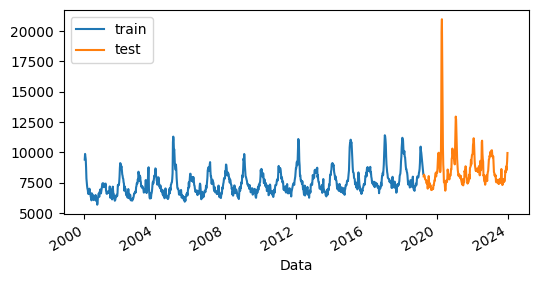

In [46]:
import matplotlib.pyplot as plt

# Dividir les dades en conjunts d'entrenament i de prova

steps=int(len(df)*0.2) # Agafem el 20% de pasos
data_train=df[:-steps]
data_test=df[-steps:]

# Dibuixem la divisió

fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();



In [47]:
# Ara fem l'entrenament amb el conjun d'entrenament
forecaster.fit(y=data_train)


/home/joamuran/devtools/miniconda3/envs/proves/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/joamuran/devtools/miniconda3/envs/proves/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [48]:
forecaster # Veiem les propietats del forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104] 
Transformer for y: None 
Transformer for exog: None 
Window size: 104 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 998] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2024-02-21 15:03:21 
Last fit date: 2024-02-21 15:03:22 
Skforecast version:


<!-- Els warnings anteriors indiquen que tenim un índex de tipus DateTimeIndex, però no estem especificant la freqüència de les dades. En el nostre cas, aquesta seria setmanal, pel que caldria remostrejar les dades com a:

```py
df = df.asfreq('W')
```

De tota manera, això requereix que les dades proporcionades coindicisquen amb períodes setmanals, ja que contràriament, aquests s'emplenarien amb valors nuls.

Si no es compleixen aquests requisits, podem ignorar els warnings.-->

In [49]:
# Una vegada entrenat, llancem les prediccions
prediccions = forecaster.predict(steps=steps)

/home/joamuran/devtools/miniconda3/envs/proves/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [50]:
prediccions.head()

104    7987.508586
105    7920.569580
106    7927.141925
107    7811.603427
108    7659.981451
Name: pred, dtype: float64

In [51]:
# Definim una funció per calular mètriques

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


def mostraMetriques(y_test, y_pred):
    eam=mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print('EAM: %f' % eam)
    print('MSE: %f' % mse)
    print('RMSE: %f' % rmse)
    print('R2: %f' % r2)

In [52]:
prediccions.index=data_test.index

In [53]:
# I l'apliquem
mostraMetriques(data_test, prediccions)

EAM: 700.039984
MSE: 2327513.055308
RMSE: 1525.618909
R2: 0.141451


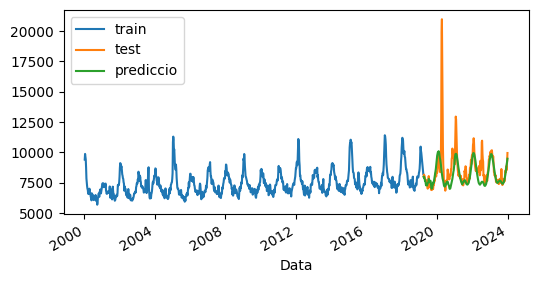

In [57]:
# Dibuixem les sèries
import matplotlib.pyplot as plt

# Dividir les dades en conjunts d'entrenament i de prova

# Dibuixem la divisió

fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
prediccions.plot(ax=ax, label='prediccio')
ax.legend();

Què ha passat aci? 

Feu una ullada a l'article [Skforecast: forecasting series temporales con Python y Scikit-learn](https://cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html), de Joaquin Amat Rodrigo, i intenteu donar-li una explicació a través del què s'exposa a l'article. Què passaria si ampliàrem el paràmetre del nombre de lags?

També us pot resultar interessant l'article [Recursive multi-step forecasting](https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/autoregresive-forecaster.html) de la mateixa documentació del projecte.